In [25]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  []


In [96]:
(train_ds, val_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

#tfds.show_examples(train_ds, ds_info)

In [130]:
# gets in a dataset and returns target values
def prepare_data(dataset, batch_size, noise_variance):
    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, targets: (tf.cast(img, tf.float32), targets))

    # convert image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, targets: ((img/128.)-1., targets))

    # add extra dimension for color channel
    #dataset = dataset.map(lambda img, targets: (tf.expand_dims(img, axis=-1), targets))

    # replace targets with initial img, replace initial img with img+noise
    dataset = dataset.map(lambda img, targets: (img + tf.random.normal(img.shape, mean=0, stddev=noise_variance), targets))

    # search for max and normalize with it again in order to keep the range of [-1, 1]
    # simultanously switch img -> noisy img, target -> img (not here, because show examples wouldnt work)
    dataset = dataset.map(lambda img, target: (img/tf.reduce_max(tf.math.abs(img)), target))

    
    #dataset = dataset.cache()
    #dataset = dataset.shuffle(4096)
    #dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

(28, 28, 1)
(28, 28, 1)


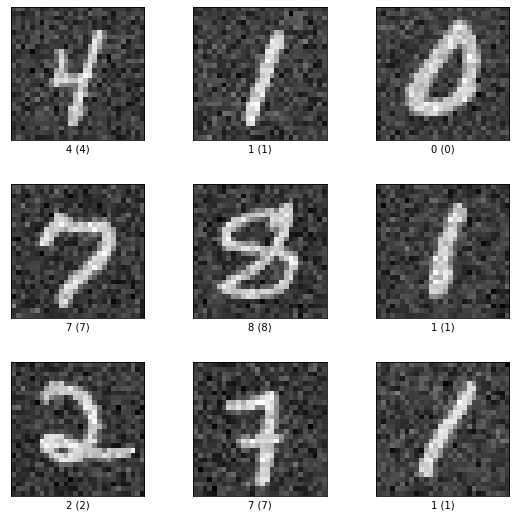

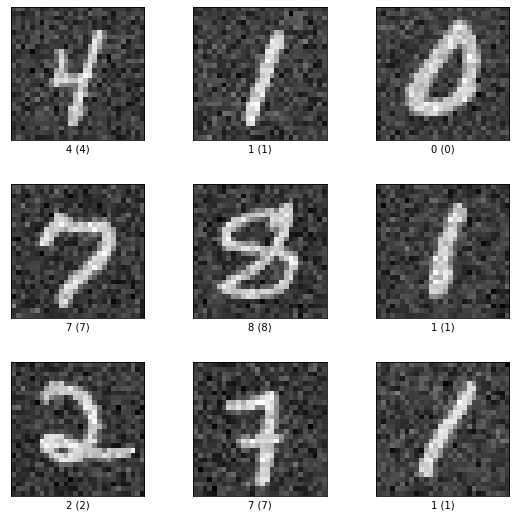

In [131]:
train_dataset = prepare_data(train_ds, 32, 0.25)
#train_dataset = train_ds.apply(lambda dataset: prepare_data(dataset, 32))
val_dataset = prepare_data(val_ds, 32, 0.25)
#val_dataset = val_ds.apply(lambda dataset: prepare_data(dataset, 32))

for img, label in train_dataset.take(2):
    print(img.shape)

tfds.show_examples(train_dataset, ds_info)

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self, seq_size, optimizer=tf.keras.optimizers.Adam()):
        super(Encoder, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
  
        self.pooling = tf.keras.layers.MaxPooling2D()
        self.my_layers = [
                        ]



    @tf.function
    def call(self, x, training=False):
        return x

    @tf.function
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm

    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list

    # 4. reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    """
    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update metrics
        self.metrics_list[1][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[1][1].update_state(loss)
        self.metrics_list[1][2].update_state(self.compute_frobenius())
        
        # return a dict with metric information
        return {m.name : m.result() for m in self.metrics_list[1]}



    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # update metrics
        self.metrics_list[0][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[0][1].update_state(loss)
        self.metrics_list[0][2].update_state(self.compute_frobenius())

        # return a dict with metric information 
        return {m.name : m.result() for m in self.metrics_list[0]}
    """

In [30]:

def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

In [31]:
# trains the model by iterating through the dataset and applying training_step method epochs time
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, memory):
    metrics = []

    # iterate over epochs
    for epoch in tqdm(range(epochs)):

        # train steps on all batches in the training data
        for (img, label) in train_ds:
            metrics = model.train_step((img, label))
            
            # keep data in summary with metrics
            with train_summary_writer.as_default():
                for metric in model.metrics_list[1]:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        for (key, value) in metrics.items():
            memory[key].append(value.numpy())

        memory = test_loop(model=model,
                           test_ds=test_ds,
                           val_summary_writer=val_summary_writer,
                           memory=memory)
        
        # print current metric values and reset the metrics
        tf.print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])
        model.reset_metrics(1)

    return memory


# tests overall performance of model
def test_loop(model, test_ds, val_summary_writer, memory):
    metrics = []
    # test steps on every item in test dataset
    for (img, label) in tqdm(test_ds):
        metrics = model.test_step((img, label))
        
        # keep data with metrics
        with val_summary_writer.as_default():
            for metric in model.metrics_list[0]:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    for (key, value) in metrics.items():
        memory[key].append(value.numpy())

    print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])

    model.reset_metrics(0)

    return memory

# visualize accuracy, loss and frobenius norm
def visualization(accuracies, losses, frobenius, name):
    plt.figure()
    line1, = plt.plot(accuracies, "b")
    line2, = plt.plot(losses, "r")

    frob_new = frobenius/np.max(frobenius) * np.max(losses)
    line3, = plt.plot(frob_new, "y" )

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3),("Accuracy", "Loss", "Frobenius Norm"))
    plt.savefig(name)
    plt.show()


In [32]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 15
batch_size = 32
seq_size = 4

## no augmentation, normal model

In [33]:
train_summary_writer, val_summary_writer = create_summary_writers(config_name="UNTOUCHED")

model = BasicConv(seq_size)


#for img, label in train_ds.take(1):
#    print(img.shape)
#    print(label.shape)

train_dataset = prepare_data(train_ds, seq_size, batch_size)
#train_dataset = train_ds.apply(lambda dataset: prepare_data(dataset, seq_size, batch_size))
val_dataset = prepare_data(val_ds, seq_size, batch_size)
#val_dataset = val_ds.apply(lambda dataset: prepare_data(dataset, seq_size, batch_size))

#for img, label in train_dataset.take(1):
#    print(img.shape)
#    print(label.shape)

NameError: name 'BasicConv' is not defined

In [ ]:
#Test compile
#print(train_dataset)
#for imgs, targets in train_dataset.take(1):
#  print(targets)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error', 
              metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                      #tf.keras.metrics.Mean(name="frob_norm")
                      ]
              )

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)

model.summary()

Epoch 1/20
469/469 [==============================] - 22s 44ms/step - loss: 0.0383 - accuracy: 0.1342 - val_loss: 0.0381 - val_accuracy: 0.0848
Epoch 2/20
469/469 [==============================] - 19s 41ms/step - loss: 0.0380 - accuracy: 0.1251 - val_loss: 0.0380 - val_accuracy: 0.0843
Epoch 3/20
314/469 [===================>..........] - ETA: 6s - loss: 0.0380 - accuracy: 0.1382

KeyboardInterrupt: 

In [ ]:
"""
tfds.benchmark(train_dataset, batch_size=batch_size)

print("\n************ Training UNTOUCHED ************\n")

memory = {"test_accuracy" : [],
          "test_loss" : [],
          "test_frob_norm" : [],
          "train_accuracy" : [],
          "train_loss" : [],
          "train_frob_norm" : []
          }

memory = training_loop(model,
                       train_ds=train_dataset,
                       test_ds=val_dataset,
                       epochs=tf.constant(epochs),
                       train_summary_writer=train_summary_writer,
                       memory=memory)

visualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")
"""

'\ntfds.benchmark(train_dataset, batch_size=batch_size)\n\nprint("\n************ Training UNTOUCHED ************\n")\n\nmemory = {"test_accuracy" : [],\n          "test_loss" : [],\n          "test_frob_norm" : [],\n          "train_accuracy" : [],\n          "train_loss" : [],\n          "train_frob_norm" : []\n          }\n\nmemory = training_loop(model,\n                       train_ds=train_dataset,\n                       test_ds=val_dataset,\n                       epochs=tf.constant(epochs),\n                       train_summary_writer=train_summary_writer,\n                       memory=memory)\n\nvisualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")\n'